<b>Diabetes Data Set</b> (reference to UCI Machine Learning Repository <a href="https://archive.ics.uci.edu/ml/datasets/diabetes">description</a>)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display

import numpy as np
import pandas as pd
from collections import Counter
import os, pickle    

from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.ensemble import (ExtraTreesClassifier, RandomForestClassifier, 
                              AdaBoostClassifier, GradientBoostingClassifier)
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit, KFold
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
from sklearn.model_selection import validation_curve
from imblearn.pipeline import Pipeline

from lib.utils import *

import warnings
warnings.simplefilter("ignore")

In [2]:
# Hyperparameters
HP = HYPERPARAMETERS({
    "GPU"                 : True ,
    "SEED"                : 0
})

In [3]:
# Seed random generators for repro 
np.random.seed(HP.SEED)  

In [4]:
# https://archive.ics.uci.edu/ml/datasets/diabetes
dataframe = pd.read_csv("data/diabetic_data.csv")
dataframe.drop('encounter_id', axis=1, inplace=True)
dataframe.drop('patient_nbr', axis=1, inplace=True)
dataframe.drop('payer_code', axis=1, inplace=True)
dataframe.drop('weight', axis=1, inplace=True)

In [5]:
dataframe['readmitted'] = dataframe['readmitted'].apply(lambda x: 1 if x == '<30' else 0)

cols = list(dataframe)
cols.insert(0, cols.pop(cols.index('readmitted')))
dataframe = dataframe.loc[:, cols]

feature_names = dataframe.columns[1:]
target_names = ['no', 'readmitted']

# Transform data form categorial to numeric
cat_variables = [i for i in dataframe.columns[1:] if dataframe[i].dtype == 'object']
encods = [LabelEncoder() for col in cat_variables]
for i, col in enumerate(cat_variables):
    dataframe[col] = encods[i].fit_transform(dataframe[col].astype(str))
    
data = dataframe

In [6]:
X = np.float32(data.values[:,1:])
y = np.int64(data.values[:,0])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=HP.SEED)

dataset_statistics(X_train, y_train, X_test, y_test, target_names)


Dataset statistics:
number of features:       45
number of classes:        2
data type:                float32
number of train samples:  81412 (pos=9116, neg=72296, size=14MB)
number of test samples:   20354 (pos=2241, neg=18113, size=3MB)
labels                    ['no', 'readmitted']


In [7]:
pipelines =  [
     {'ExtraTreesClassifier1': Pipeline(steps=[
                ('scaler',     StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('outlier',    OutlierSampler(8.5)),
                ('sampler',    SMOTE(ratio='auto', random_state=HP.SEED)),
                ('classifier', ExtraTreesClassifier())
                ])},
     {'ExtraTreesClassifier2': Pipeline(steps=[
                ('outlier',    OutlierSampler(8.5)),
                ('sampler',    RandomOverSampler(ratio='auto', random_state=HP.SEED)),
                ('classifier', ExtraTreesClassifier())
                ])},
     {'RandomForestClassifier1': Pipeline(steps=[
                ('scaler',     StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('outlier',    OutlierSampler(8.5)),
                ('sampler',    SMOTE(ratio='auto', random_state=HP.SEED)),
                ('classifier', RandomForestClassifier())
                ])},
     {'RandomForestClassifier2': Pipeline(steps=[
                ('scaler',     MinMaxScaler(copy=True)),
                ('outlier',    OutlierSampler(8.5)),
                ('sampler',    RandomOverSampler(ratio='auto', random_state=HP.SEED)),
                ('classifier', RandomForestClassifier())
                ])},
     {'GradientBoostingClassifier1': Pipeline(steps=[
                ('scaler',     MinMaxScaler(copy=True)),
                ('outlier',    OutlierSampler(8.5)),
                ('sampler',    RandomOverSampler(ratio='auto', random_state=HP.SEED)),
                ('classifier', GradientBoostingClassifier())
                ])},
     {'GradientBoostingClassifier2': Pipeline(steps=[
                ('scaler',     StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('outlier',    OutlierSampler(8.5)),
                ('sampler',    SMOTE(ratio='auto', random_state=HP.SEED)),
                ('classifier', GradientBoostingClassifier())
                ])},
#      {'SVC1': Pipeline(steps=[
#                 ('scaler',     StandardScaler(copy=True, with_mean=True, with_std=True)),
#                 ('outlier',    OutlierSampler(8.5)),
#                 ('sampler',    SMOTE(ratio='auto', random_state=HP.SEED)),
#                 ('classifier', SVC())
#                 ])},
#      {'SVC2': Pipeline(steps=[
#                 ('outlier',    OutlierSampler(8.5)),
#                 ('sampler',    RandomOverSampler(ratio='auto', random_state=HP.SEED)),
#                 ('classifier', SVC())
#                 ])},
#      {'LogisticRegression1': Pipeline(steps=[
#                 ('scaler',     StandardScaler(copy=True, with_mean=True, with_std=True)),
#                 ('outlier',    OutlierSampler(8.5)),
#                 ('sampler',    SMOTE(ratio='auto', random_state=HP.SEED)),
#                 ('classifier', LogisticRegression())
#                 ])},
#     {'LogisticRegression2': Pipeline(steps=[
#                 ('outlier',    OutlierSampler(8.5)),
#                 ('sampler',    RandomOverSampler(ratio='auto', random_state=HP.SEED)),
#                 ('classifier', LogisticRegression())
#                 ])},
]

In [8]:
parameters = [
     {'ExtraTreesClassifier1': 
      { 'classifier__n_estimators'      : [8, 16, 32] ,
        'classifier__max_features'      : ['auto', 'sqrt', 'log2', None],
        "classifier__max_depth"         : [1, 10, 20],
        "classifier__min_samples_split" : [2, 4] ,
        "classifier__bootstrap"         : [True, False]
      }},
     {'ExtraTreesClassifier2': 
      { 'classifier__n_estimators'      : [8, 16, 32] ,
        'classifier__max_features'      : ['auto', 'sqrt', 'log2', None],
        "classifier__max_depth"         : [1, 10, 20],
        "classifier__min_samples_split" : [2, 4] ,
        "classifier__bootstrap"         : [True, False]
      }},
     {'RandomForestClassifier1': 
      { 'classifier__n_estimators'      : [8, 32, 64] ,
        "classifier__criterion"         : ["gini", "entropy"],
        'classifier__max_features'      : ['auto', 'sqrt', 'log2', None],
        "classifier__max_depth"         : [1, 10, 20],
        "classifier__min_samples_split" : [2, 4] ,
        "classifier__bootstrap"         : [True, False]
      }},
      {'RandomForestClassifier2': 
       { 'classifier__n_estimators'      : [8, 32, 64] ,
        "classifier__criterion"         : ["gini", "entropy"],
        'classifier__max_features'      : ['auto', 'sqrt', 'log2', None],
        "classifier__max_depth"         : [1, 10, 20],
        "classifier__min_samples_split" : [2, 4] ,
        "classifier__bootstrap"         : [True, False]
      }},
     {'GradientBoostingClassifier1': 
      { 'classifier__n_estimators': [16, 32], 
        'classifier__learning_rate': [0.1, 0.05, 0.02, 0.01],
        'classifier__max_depth': [4, 6, 8],
        'classifier__min_samples_leaf': [20, 50,100,150],
        'classifier__max_features': [1.0, 0.3, 0.1]        
      }},
     {'GradientBoostingClassifier2': 
      { 'classifier__n_estimators': [16, 32], 
        'classifier__learning_rate': [0.1, 0.05, 0.02, 0.01],
        'classifier__max_depth': [4, 6, 8],
        'classifier__min_samples_leaf': [20, 50,100,150],
        'classifier__max_features': [1.0, 0.3, 0.1]        
      }},
#     {'SVC1': [
#         {'classifier__kernel': ['rbf'], 
#          'classifier__gamma': [1e-3, 1e-4],
#          'classifier__C': [0.1, 1, 10, 100, 1000]},
#         {'classifier__kernel': ['linear'], 
#          'classifier__C': [0.1, 1, 10, 100, 1000]}
#     ]},
#     {'SVC2': [
#         {'classifier__kernel': ['rbf'], 
#          'classifier__gamma': [1e-3, 1e-4],
#          'classifier__C': [0.1, 1, 10, 100, 1000]},
#         {'classifier__kernel': ['linear'], 
#          'classifier__C': [0.1, 1, 10, 100, 1000]}
#     ]},
#     {'LogisticRegression1': [
#         {'classifier__solver': ['newton-cg',  'lbfgs' , 'sag' ],
#          'classifier__C': np.logspace(-10, 10, 5),            
#          'classifier__fit_intercept': [True, False],
#          'classifier__max_iter' : [50, 100, 200],
#          'classifier__intercept_scaling' : [0.5, 1.0, 1.5]
#         },
#         {'classifier__solver': ['liblinear'],
#          'classifier__penalty': ['l1', 'l2'],
#          'classifier__C': np.logspace(-10, 10, 5),            
#          'classifier__fit_intercept': [True, False],
#          'classifier__max_iter' : [50, 100, 200],
#          'classifier__intercept_scaling' : [0.5, 1.0, 1.5]
#         }   
#     ]},
#     {'LogisticRegression2': [
#         {'classifier__solver': ['newton-cg',  'lbfgs' , 'sag' ],
#          'classifier__C': np.logspace(-10, 10, 5),            
#          'classifier__fit_intercept': [True, False],
#          'classifier__max_iter' : [50, 100, 200],
#          'classifier__intercept_scaling' : [0.5, 1.0, 1.5]
#         },
#         {'classifier__solver': ['liblinear'],
#          'classifier__penalty': ['l1', 'l2'],
#          'classifier__C': np.logspace(-10, 10, 5),            
#          'classifier__fit_intercept': [True, False],
#          'classifier__max_iter' : [50, 100, 200],
#          'classifier__intercept_scaling' : [0.5, 1.0, 1.5]
#         }      
#    ]}
]

scoring = 'f1'

In [9]:
NUM_TRIALS = 3

trial_scores_columns = ['name', 'best_score', 'best_parameters', 'pipeline',
                        'trial', 'score_mean', 'score_std', 'score_min', 'score_max']
trial_scores = pd.DataFrame(columns=trial_scores_columns)
for trial in tqdm(range(NUM_TRIALS)):
    
    model_select_columns = ['trail', 'idx', 'name', 'best_score', 'best_parameters', 'pipeline']
    model_select = pd.DataFrame(columns=model_select_columns)
    for idx, (pip, params) in enumerate(zip(pipelines, parameters)):
        pipeline_name, pipeline = list(pip.items())[0]
        _, pipeline_parameters = list(params.items())[0]

        cv = KFold(n_splits=4, shuffle=True, random_state=trial)
        gscv = GridSearchCV(estimator=pipeline, param_grid=pipeline_parameters, scoring=scoring, cv=cv, 
                            verbose=0, n_jobs=-1)
        gscv.fit(X_train, y_train)
        
        model_select = model_select.append(pd.DataFrame([[
            trial, idx, pipeline_name, gscv.best_score_, gscv.best_params_ , pickle.dumps(gscv.best_estimator_)
        ]], columns=model_select_columns))
            
    best_trail = model_select.groupby(['name'])['best_score'].agg(['mean', 'std', 'min', 'max']).sort_values('mean', ascending=False).iloc[0]
    best_pipeline = model_select[model_select['name'] == best_trail.name].sort_values('best_score', ascending=False).iloc[0]
      
    pipeline = pickle.loads(best_pipeline['pipeline'])
    parameter = best_pipeline['best_parameters']
            
    cv = KFold(n_splits=10, shuffle=True, random_state=trial).split(X_train)
    scores = cross_validate(pipeline, X_train, y_train, cv=cv, return_train_score=True, 
                            verbose=0, n_jobs=-1)['test_score']
    
    trial_scores = trial_scores.append(pd.DataFrame([[
        best_pipeline['name'], best_pipeline['best_score'], parameter, pickle.dumps(pipeline),
        trial, np.mean(scores), np.std(scores), np.min(scores), np.max(scores)
    ]], columns=trial_scores_columns))
    

100%|██████████| 3/3 [2:24:55<00:00, 2898.48s/it]


In [10]:
trial_scores.sort_values("score_mean", ascending=True).head(100)

,name,best_score,best_parameters,pipeline,trial,score_mean,score_std,score_min,score_max
0,GradientBoostingClassifier1,0.266945,"{'classifier__learning_rate': 0.1, 'classifier...",b'\x80\x03cimblearn.pipeline\nPipeline\nq\x00)...,0,0.647165,0.008883,0.626582,0.658641
0,GradientBoostingClassifier1,0.267237,"{'classifier__learning_rate': 0.02, 'classifie...",b'\x80\x03cimblearn.pipeline\nPipeline\nq\x00)...,2,0.653786,0.007961,0.638005,0.662245
0,GradientBoostingClassifier1,0.266710,"{'classifier__learning_rate': 0.05, 'classifie...",b'\x80\x03cimblearn.pipeline\nPipeline\nq\x00)...,1,0.654805,0.007771,0.644761,0.667854


In [11]:
trial_scores['best_parameters_hash'] = trial_scores['best_parameters'].apply(lambda x : hash(str(x)))
trial_selected = trial_scores.groupby(['name', 'best_parameters_hash'])['score_mean'].agg(['count']).sort_values('count', ascending=False).iloc[0]
df_tmp = trial_scores[(trial_scores['name'].str.contains(trial_selected.name[0]))]
trial_clf = df_tmp[(df_tmp['best_parameters_hash'] == trial_selected.name[1])].iloc[0]
trial_clf

name                                          GradientBoostingClassifier1
best_score                                                        0.26671
best_parameters         {'classifier__learning_rate': 0.05, 'classifie...
pipeline                b'\x80\x03cimblearn.pipeline\nPipeline\nq\x00)...
trial                                                                   1
score_mean                                                       0.654805
score_std                                                      0.00777121
score_min                                                        0.644761
score_max                                                        0.667854
best_parameters_hash                                  -119754997420338452
Name: 0, dtype: object

In [12]:
pipeline = pickle.loads(trial_clf['pipeline'])
params = trial_clf['best_parameters']

for pip_name in pipeline.named_steps:
    display(pipeline.named_steps[pip_name])
    
params

MinMaxScaler(copy=True, feature_range=(0, 1))

OutlierSampler(memory=None, threshold=8.5, verbose=0)

RandomOverSampler(random_state=0, ratio='auto')

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=8,
              max_features=0.3, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=100, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=32,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

{'classifier__learning_rate': 0.05,
 'classifier__max_depth': 8,
 'classifier__max_features': 0.3,
 'classifier__min_samples_leaf': 100,
 'classifier__n_estimators': 32}

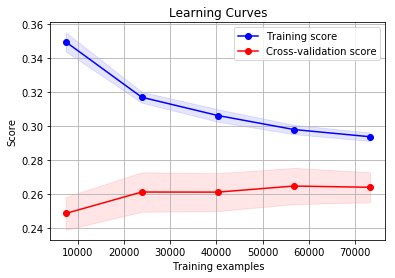

In [13]:
cv = KFold(n_splits=10, shuffle=True, random_state=HP.SEED).split(X_train)
_ = plot_learning_curve(pipeline, 'Learning Curves', X_train, y_train, 
                    cv=cv, scoring=scoring, shuffle=True, random_state=HP.SEED)

In [18]:
# from sklearn.learning_curve import validation_curve
# param_name = 'n_estimators'
# param_range = [ 25, 32, 40]
# # param_name = 'classifier__max_depth'
# # param_range = [ 2, 5, 10, 15, 20]
# train_scores, test_scores = validation_curve(
#                 estimator=pipeline,
#                  X=X_train,
#                  y=y_train,
#                  param_name=param_name,
#                  scoring='accuracy',
#                  param_range=param_range,
#                  cv=10)

# train_mean = np.mean(train_scores, axis=1)
# train_std = np.std(train_scores, axis=1)
# test_mean = np.mean(test_scores, axis=1)
# test_std = np.std(test_scores, axis=1)


# plt.plot(param_range, train_mean,
#           color='blue', marker='o',
#           markersize=5,
#           label='training accuracy')
# plt.fill_between(param_range, train_mean + train_std,
#                   train_mean - train_std, alpha=0.15,
#                   color='blue')
# plt.plot(param_range, test_mean,
#           color='green', linestyle='--',
#           marker='s', markersize=5,
#           label='validation accuracy')
# plt.fill_between(param_range,
#                   test_mean + test_std,
#                   test_mean - test_std,
#                   alpha=0.15, color='green')
# plt.grid()
# #plt.xscale('log')
# plt.legend(loc='lower right')
# plt.xlabel('Parameter C')
# plt.ylabel('Accuracy')
# plt.ylim([0.8, 1.0])
# plt.show()

Trainings score: 0.29295573055871593 0.002336763326854489
Validation score: 0.26497190423623407 0.008920105577281134


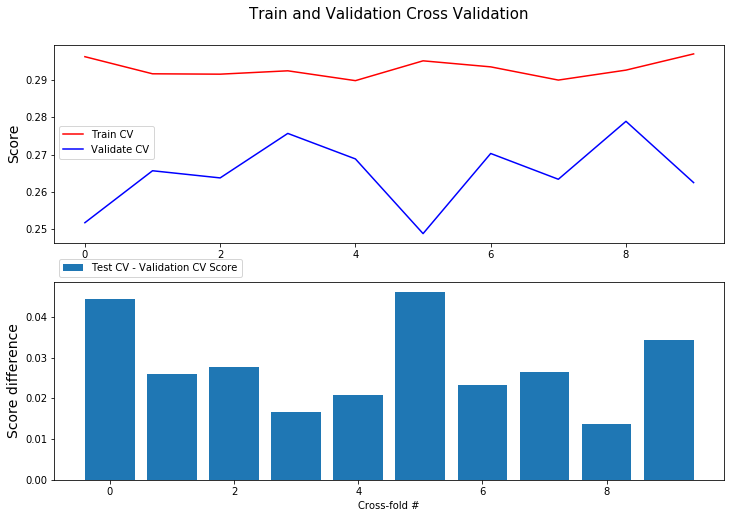

In [19]:
# Cross-validate to train best model 
cv = KFold(n_splits=10, shuffle=True, random_state=HP.SEED).split(X_train)
scores = cross_validate(pipeline, X_train, y_train, cv=cv, scoring=scoring, return_train_score=True, 
                        verbose=0, n_jobs=-1)

print("Trainings score:", np.mean(scores['train_score']), np.std(scores['train_score']))
print("Validation score:", np.mean(scores['test_score']), np.std(scores['test_score']))
plot_cross_validation_scores(scores, figsize=(12, 8))

In [20]:
# http://www.ritchieng.com/machine-learning-evaluate-classification-model/
# https://github.com/justmarkham/DAT8/blob/master/other/model_evaluation_comparison.md\
# Accuracy of a model that simply counts, i.e. looks at the prior distribution

y_pred = pipeline.predict(X_test)
try:
    y_prob = pipeline.predict_proba(X_test)
except:
    pass

print('Confusion Matrix\n', metrics.confusion_matrix(y_test, y_pred))  # Confusion Matrix
print('Accuracy ', metrics.accuracy_score(y_test, y_pred))            # Accuracy (TP + TN) / float(TP + TN + FP + FN)
print('Recall   ', metrics.recall_score(y_test, y_pred))                # Recall (Sensitivity)   TP / float(FN + TP)
print('Precision', metrics.precision_score(y_test, y_pred))     
print('F1       ', metrics.f1_score(y_test, y_pred))     
print('ROC AUC  ', metrics.roc_auc_score(y_test, y_pred))     

Confusion Matrix
 [[11968  6145]
 [ 1008  1233]]
Accuracy  0.6485703055910386
Recall    0.5502008032128514
Precision 0.16711846028734073
F1        0.2563676057802266
ROC AUC   0.6054708537678567


In [21]:
#  Cross-validate score on test set
cv = KFold(n_splits=10, shuffle=True, random_state=HP.SEED).split(X_test)
scores = cross_val_score(pipeline, X_test, y_test, cv=cv, scoring='accuracy', 
                         verbose=0, n_jobs=-1)

print("Test accuracy score:", np.mean(scores), np.std(scores))

Test accuracy score: 0.7100820851213779 0.010307320777329695
